In [149]:
import pandas as pd
import numpy as np


<div style="background-color: rgba(255, 255, 0, 0.25); color: black; padding: 10px;">
    <h1>Functions</h1>
</div>


In [496]:
def format_number(val):  
    if isinstance(val, (int, float)):
        return f"{val:.1f}"
    return val

def get_desc(df):
    result_table = pd.DataFrame(df.dtypes, columns=['data type'])
    result_table['#missing'] = df.isnull().sum().values
    result_table['%missing'] = np.round(df.isnull().sum().values / len(df) * 100, 1)
    result_table['#unique'] = df.nunique().values
    
    desc = pd.DataFrame(df.describe(include='all', percentiles=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]).transpose())
    
    for percentile in ['min', 'max', '1%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '99%']:  
        result_table[percentile] = desc[percentile].apply(format_number).values
        
    return result_table

In [455]:
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd


def encode(X_train, y_train, X_test, categorical_features, encoder_type):
    if encoder_type == 'target':
        encoder = TargetEncoder(cols=categorical_features)
        X_train_encoded = encoder.fit_transform(X_train, y_train)
        X_test_encoded = encoder.transform(X_test)
        
    elif encoder_type == 'onehot':
        encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        X_train_categorical = encoder.fit_transform(X_train[categorical_features])
        X_test_categorical = encoder.transform(X_test[categorical_features])
        
        X_train_categorical = pd.DataFrame(X_train_categorical, index=X_train.index, columns=encoder.get_feature_names(categorical_features))
        X_test_categorical = pd.DataFrame(X_test_categorical, index=X_test.index, columns=encoder.get_feature_names(categorical_features))
        
        X_train_encoded = pd.concat([X_train.drop(columns=categorical_features), X_train_categorical], axis=1)
        X_test_encoded = pd.concat([X_test.drop(columns=categorical_features), X_test_categorical], axis=1)
    
    elif encoder_type == 'label':
        encoder = LabelEncoder()
        X_train_encoded = X_train.copy()
        X_test_encoded = X_test.copy()

        for feature in categorical_features:
            combined = pd.concat([X_train[feature], X_test[feature]], axis=0)
            encoder.fit(combined)
            X_train_encoded[feature] = encoder.fit_transform(X_train[feature])
            X_test_encoded[feature] = encoder.fit_transform(X_test[feature])
        
    elif encoder_type == 'binary':
        encoder = BinaryEncoder(cols=categorical_features)
        X_train_encoded = encoder.fit_transform(X_train)
        X_test_encoded = encoder.transform(X_test)
        
    elif encoder_type == 'frequency':
        X_train_encoded = X_train.copy()
        X_test_encoded = X_test.copy()
        for feature in categorical_features:
            freq = X_train[feature].value_counts() / len(X_train)
            X_train_encoded[feature] = X_train[feature].map(freq)
            X_test_encoded[feature] = X_test[feature].map(freq).fillna(0)
        
    else:
        print('Неверное название кодировщика')
        return None, None, None
    
    return X_train_encoded, X_test_encoded


In [456]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

def converter(df, features_to_convert, method='standard'):
    df_normalized = df.copy()
    
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'maxabs':
        scaler = MaxAbsScaler()
    elif method == 'log':
        scaler = None
        df_normalized[features_to_convert] = np.sign(df[features_to_convert]) * np.log(np.abs(df[features_to_convert]+0.000001))
        return df_normalized
    elif method == 'sqrt':
        scaler = None
        df_normalized[features_to_convert] = np.sqrt(df[features_to_convert])
        return df_normalized
    elif method == 'recip':
        scaler = None
        df_normalized[features_to_convert] = np.reciprocal(df[features_to_convert])
        return df_normalized    
    
    else:
        print('Неизвестный метод нормализации')
        return None, None
    
    df_normalized[features_to_convert] = scaler.fit_transform(df[features_to_convert])
   
    return df_normalized

In [457]:
import scipy.stats as stats  
from scipy.stats import probplot

def convert(df,numeric_features):  
    r2_scores = pd.DataFrame()  
    
    for feature in numeric_features:  
        orig = df[feature].dropna()  
        
        R_orig = probplot(orig, rvalue=True)[1][2]**2  
        R_log =probplot(np.sign(orig)*np.log(np.abs(orig+0.00000001)), rvalue=True)[1][2]**2  
        R_sqrt = probplot(np.sqrt(orig), rvalue=True)[1][2]**2  
        R_reci = probplot(np.reciprocal(orig), rvalue=True)[1][2]**2  
        #R_boxcox = probplot(stats.boxcox(orig)[0], rvalue=True)[1][2]**2  
        R_yeojohn = probplot(stats.yeojohnson(orig)[0], rvalue=True)[1][2]**2  
        
        d = pd.DataFrame({  
        'Original': [R_orig],  
        'Log': [R_log],  
        'Sqrt': [R_sqrt],  
        'Reciprocal': [R_reci],  # функции обратной величины
        #'BoxCox': [R_boxcox],  
        #'YeoJohnson': [R_yeojohn]  
        }, index=[feature])  
            
        r2_scores = pd.concat([r2_scores, d], axis=0)  
        
    r2_scores["Winner"] = r2_scores.idxmax(axis=1)  
    return r2_scores

In [624]:
def valuation (model, X_test,y_test, threshold = 0.5):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_threshold = np.where(y_pred_proba >= threshold, 1, 0)

    # Расчет метрик
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("Порог:", threshold)
    print("Precision:", precision)
    print("Recall:", recall)
    print("ROC AUC:", roc_auc)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def valuation_r (model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")

<div style="background-color: rgba(255, 255, 0, 0.25); color: black; padding: 10px;">
    <h1>Charts</h1>
</div>


In [671]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats



def chart_result_analysis (model, X_test, y_test):
   
    # Предсказания модели
    y_pred = model.predict(X_test)
    # Вычисление остатков
    residuals = y_test - y_pred

    # График предсказаний. Идеальный - точно следует за линией. Где отклоняется в тех значениях таргета ошибается.
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label='Предсказанные значения')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Идеальная линия')
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title('Сравнение фактических и предсказанных значений')
    plt.legend()
    plt.show()


    # График поведения остатков. Идеально когда остатки близки к нулю и равномерно распределены выши и ниже без выбросов.
    # График должен быть без существенных выбросов в форме колокола. Есть выбросы - значит выбросы влияют. 
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.title('График остатков против предсказанных значений')
    plt.show()


    # Q-Q график для оценки нормальности остатков
    plt.figure(figsize=(10, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q график остатков')
    plt.show()

# Classification

In [527]:
data = pd.read_csv( './Other/baselines/ds_salaries.csv', sep= ',')
data['target'] = -1
data.loc[data.company_size=='S','target'] = 1
data.loc[data.company_size=='M','target'] = 0
data.loc[data.company_size=='L','target'] = 0
data.drop(['salary','salary_currency','company_size'], inplace = True, axis =1)
df = data.copy()

In [519]:
get_desc(df)

,data type,#missing,%missing,#unique,min,max,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%
work_year,int64,0,0.0,4,2020.0,2023.0,2020.0,2022.0,2022.0,2022.0,2022.0,2022.0,2023.0,2023.0,2023.0,2023.0,2023.0
experience_level,object,0,0.0,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
employment_type,object,0,0.0,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
job_title,object,0,0.0,93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
salary_in_usd,int64,0,0.0,1035,5132.0,450000.0,12826.4,59537.0,83972.8,104000.0,120000.0,135000.0,149850.0,165000.0,185900.0,219000.0,309400.0
employee_residence,object,0,0.0,78,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
remote_ratio,int64,0,0.0,3,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,100.0,100.0
company_location,object,0,0.0,72,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
target,int64,0,0.0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<div style="background-color: rgba(255, 255, 0, 0.1); color: black; padding: 10px;">
    <h2>Linear</h2>
</div>

In [520]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [ ]:
categorical_features = list(df.select_dtypes(include=['object']).columns)
numeric_features = list(set(df.columns) - (set(categorical_features) | set(['target'])))

# qq для определения преобразующей функци
qq_check = convert(df,numeric_features)

# преобразования
df_tmp = converter(df, ['salary_in_usd'], method='sqrt')
df = converter(df_tmp, numeric_features, method='standard')

# разделение и конвертация
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

X_train_encoded, X_test_encoded =  encode(X_train, y_train, X_test, categorical_features, 'onehot')

### Модель

In [522]:
model = LogisticRegression()
model.fit(X_train_encoded, y_train)

params = {
    'penalty': 'l2', #Регуляризация (тип штрафа за высокий вес)     l1, l2, elasticnet
    'tol': 1e-4, # порог для остановки алгоритма. Если измеFнения ф-потерь меньшем указаного
    'C': 1.0, # #Регуляризация сила [0.01,0.1,1,10] Чем меньше, тем больше сила
    'fit_intercept': True, # стоит ли добавлять свободный член
    'class_weight': {0:0.5, 1:0.5}, # none, balance 
    'random_state': 42,
    'solver': 'newton-cg', # liblinear, lbfgs, newton-cg, sag, saga
     'max_iter': 500, #число итерация градиентного спуска
    'multi_class': 'auto',
    'verbose': 100
}

# Инициализация и обучение модели логистической регрессии с указанными гиперпараметрами
model = LogisticRegression(**params)
model.fit(X_train_encoded, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(class_weight={0: 0.5, 1: 0.5}, max_iter=500, random_state=42,
                   solver='newton-cg', verbose=100)

In [525]:
valuation(model, X_test_encoded, y_test, threshold=0.15)

Порог: 0.15
Precision: 0.2625
Recall: 0.7
ROC AUC: 0.9382801664355063


In [526]:
# Получение коэффициентов
weights = model.coef_[0]
intercept = model.intercept_

feature_names = X_train.columns
weights_with_features = list(zip(feature_names, weights))
print("Веса и признаки:")
for name, weight in weights_with_features:
    print(f"{name}: {round(weight,3)}")

Веса и признаки:
work_year: -0.552
experience_level: -0.49
employment_type: 0.463
job_title: 0.349
salary_in_usd: 0.312
employee_residence: -0.165
remote_ratio: -0.497
company_location: 0.568


<div style="background-color: rgba(255, 255, 0, 0.1); color: black; padding: 10px;">
    <h2>RandomForest</h2>
</div>

In [531]:
from sklearn.ensemble import RandomForestClassifier

In [528]:
data = pd.read_csv( './Other/baselines/ds_salaries.csv', sep= ',')
data['target'] = -1
data.loc[data.company_size=='S','target'] = 1
data.loc[data.company_size=='M','target'] = 0
data.loc[data.company_size=='L','target'] = 0
data.drop(['salary','salary_currency','company_size'], inplace = True, axis =1)
df = data.copy()

In [ ]:
categorical_features = list(df.select_dtypes(include=['object']).columns)
numeric_features = list(set(df.columns) - (set(categorical_features) | set(['target'])))

# qq для определения преобразующей функци
qq_check = convert(df,numeric_features)

# преобразования
df_tmp = converter(df, ['salary_in_usd'], method='sqrt')
df = converter(df_tmp, numeric_features, method='standard')

# разделение и конвертация
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

X_train_encoded, X_test_encoded =  encode(X_train, y_train, X_test, categorical_features, 'onehot')

In [538]:
params = {
    'n_estimators': 100,  # количество деревьев в лесу
    'criterion': 'gini',  # критерий качества разбиения
    'max_depth': None,  # максимальная глубина дерева
    'min_samples_split': 2,  # минимальное количество объектов, необходимое для разделения внутреннего узла
    'min_samples_leaf': 1,  # минимальное количество объектов в листе
    'min_weight_fraction_leaf': 0.0,  # минимальная взвешенная доля суммы весов во всех объектах, необходимая для листа
    'max_features': 'auto',  # количество признаков, учитываемых при поиске лучшего разбиения
    'max_leaf_nodes': None,  # максимальное количество листьев
    'min_impurity_decrease': 0.0,  # уменьшение неопределенности для разделения
    'bootstrap': True,  # использование бутстрапа для построения деревьев
    'oob_score': False,  # использование out-of-bag объектов для оценки точности
    'n_jobs': 1,  # количество ядер для параллельной работы
    'random_state': None,  # контроль за случайностью
    'verbose': 0,  # уровень детализации в процессе обучения
    'warm_start': False,  # использование предыдущего решения для добавления новых деревьев в ансамбль
    'class_weight': None,  # веса классов
    'ccp_alpha': 0.0,  # параметр для минимальной стоимости комплексной прунинга
    'max_samples': None  # количество объектов для обучения каждого базового дерева
}

model = RandomForestClassifier(**params)
model.fit(X_train_encoded, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', n_jobs=1)

In [539]:
valuation(model, X_test_encoded, y_test, threshold=0.15)

Порог: 0.15
Precision: 0.21176470588235294
Recall: 0.6
ROC AUC: 0.9223069810448451


In [575]:
model.fit(X_train_encoded, y_train)

RandomForestClassifier(random_state=42)

                                Feature  Importance
0                         salary_in_usd    0.198324
1                             work_year    0.095449
2                          remote_ratio    0.050374
3                   experience_level_EN    0.022921
4  job_title_Machine Learning Scientist    0.022780
5              job_title_Data Scientist    0.021233
6                   experience_level_MI    0.020145
7                   company_location_US    0.019272
8                    employment_type_FT    0.018686
9                 employee_residence_US    0.018089


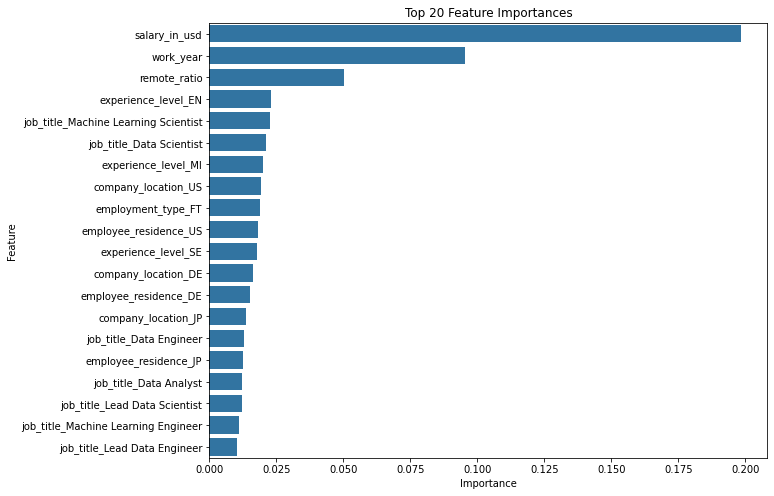

In [576]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = model.feature_importances_
features = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': feature_importances
})

features = features.sort_values(by='Importance', ascending=False).reset_index(drop=True)
print(features.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


### GRID SEARCH

In [548]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [500],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2], 
    'max_features': ['auto', 'sqrt', 'log2'],  
    'bootstrap': [True],  
    'criterion': ['gini', 'entropy'],  
    'max_leaf_nodes': [None, 10, 50] 
}


In [ ]:
model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2, n_jobs=1)
grid_search.fit(X_train_encoded, y_train)

In [550]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая ROC AUC:", grid_search.best_score_)
best_model = grid_search.best_estimator_

Лучшие параметры: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Лучшая ROC AUC: 0.9276105281811848


In [560]:
valuation(best_model, X_test_encoded, y_test, threshold =0.15)

Порог: 0.15
Precision: 0.2465753424657534
Recall: 0.6
ROC AUC: 0.9304669440591771


### RANDOM SEARCH

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Настройка параметров для RandomizedSearchCV
param_grid = {
    'n_estimators': [500],  
    'max_depth': [None, 20, 30],  
    'min_samples_split': [5,10,15],  
    'min_samples_leaf': [1, 4, 6], 
    'max_features': ['log2'],  
    'bootstrap': [True],  
    'criterion': ['entropy'],  
    'max_leaf_nodes': [None] 
}


# Инициализация RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, scoring='roc_auc', n_iter=100, cv=5, verbose=2, n_jobs=1, random_state=42)
random_search.fit(X_train_encoded, y_train)


print("Лучшие параметры:", random_search.best_params_)
print("Лучшая ROC AUC:", random_search.best_score_)


In [565]:
print("Лучшие параметры:", random_search.best_params_)
print("Лучшая ROC AUC:", random_search.best_score_)
#best_model = random_search.best_estimator_

Лучшие параметры: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': True}
Лучшая ROC AUC: 0.9276105281811848


<div style="background-color: rgba(255, 255, 0, 0.1); color: black; padding: 10px;">
    <h2>Catboost</h2>
</div>

<div style="background-color: rgba(255, 255, 0, 0.1); color: black; padding: 10px;">
    <h2>LGBM</h2>
</div>

<div style="background-color: rgba(255, 255, 0, 0.1); color: black; padding: 10px;">
    <h2>KERAS</h2>
</div>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
data = pd.read_csv( './Other/baselines/ds_salaries.csv', sep= ',')
data['target'] = -1
data.loc[data.company_size=='S','target'] = 1
data.loc[data.company_size=='M','target'] = 0
data.loc[data.company_size=='L','target'] = 0
data.drop(['salary','salary_currency','company_size'], inplace = True, axis =1)
df = data.copy()

In [ ]:
categorical_features = list(df.select_dtypes(include=['object']).columns)
numeric_features = list(set(df.columns) - (set(categorical_features) | set(['target'])))

# qq для определения преобразующей функци
qq_check = convert(df,numeric_features)

# преобразования
df_tmp = converter(df, ['salary_in_usd'], method='sqrt')
df = converter(df_tmp, numeric_features, method='standard')

# разделение и конвертация
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

X_train_encoded, X_test_encoded =  encode(X_train, y_train, X_test, categorical_features, 'onehot')

<div style="background-color: rgba(255, 255, 0, 0.1); color: black; padding: 10px;">
    <h2>Pytorch</h2>
</div>

# Regression

<div style="background-color: rgba(255, 255, 0, 0.1); color: black; padding: 10px;">
    <h2>Linear</h2>
</div>

In [764]:
data = pd.read_csv( './Other/baselines/ds_salaries.csv', sep= ',')
data['target'] = data.salary_in_usd
data.drop(['salary','salary_currency','salary_in_usd'], inplace = True, axis =1)
df = data.copy()

In [765]:
categorical_features = list(df.select_dtypes(include=['object']).columns)
numeric_features = list(set(df.columns) - (set(categorical_features) | set(['target'])))

### Feature Engineering

In [ ]:
# для числовых
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# degree=2 означает, что будут созданы все полиномиальные комбинации признаков степени до 2
# interaction_only=True гарантирует, что будут включены только произведения различных признаков,а не квадраты отдельных признаков

features_to_poly = numeric_features
new_poly = poly.fit_transform(df[features_to_poly])
new_poly_df = pd.DataFrame(new_poly_feat, columns=poly.get_feature_names(df[features_to_poly].columns))
new_poly_cols = list(set(new_poly_df.columns) - set(features_to_poly))
df[new_poly_cols] = new_poly_df[new_poly_cols]

# Переопределим переменные
categorical_features = list(df.select_dtypes(include=['object']).columns)
numeric_features = list(set(df.columns) - (set(categorical_features) | set(['target'])))

In [767]:
#для категориальных 
df['new_cat'] = df['experience_level'].astype(str)+'_'+ df['employment_type'].astype(str)

categorical_features = list(df.select_dtypes(include=['object']).columns)
numeric_features = list(set(df.columns) - (set(categorical_features) | set(['target'])))

### Preparing

In [ ]:
# qq для определения преобразующей функци
qq_check = convert(df,numeric_features)

# преобразования
df = converter(df, numeric_features, method='standard')

# разделение и конвертация
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_encoded, X_test_encoded =  encode(X_train, y_train, X_test, categorical_features, 'onehot')

### Modeling

In [769]:
from sklearn.linear_model import Ridge, Lasso

params_ridge = {
    'alpha': 0.5,  # коэффициент регуляризации
    'fit_intercept': True,  # рассчитывать свободный член (интерсепт)
    'max_iter': 100,  # максимальное число итераций
    'tol': 0.0001,  # толерантность к изменениям в весах для остановки
    'solver': 'svd',  # алгоритм решения [svd, cholesky, lsqr, sparse_cg, sag, saga
    'random_state': 42  # контроль за случайностью
}

model_ridge = Ridge(**params_ridge)
model_ridge.fit(X_train_encoded, y_train)

Ridge(alpha=0.5, max_iter=100, random_state=42, solver='svd', tol=0.0001)

In [770]:
params_lasso = {
    'alpha': 1.0,  # коэффициент регуляризации
    'fit_intercept': True,  # рассчитывать свободный член (интерсепт)
    'max_iter': 500,  # максимальное число итераций
    'tol': 0.0001,  # толерантность к изменениям в весах для остановки
    'random_state': 42,  # контроль за случайностью
}
model_lasso = Lasso(**params_lasso)
model_lasso.fit(X_train_encoded, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e+12, tolerance: 1.196e+09
  model = cd_fast.enet_coordinate_descent(


Lasso(max_iter=500, random_state=42)

### Valuation

In [771]:
print('ridge:')
valuation_r (model_ridge, X_test_encoded, y_test)
print('')
print('lasso:')
valuation_r (model_lasso, X_test_encoded, y_test)

ridge:
MSE: 2363096128.1721463
RMSE: 48611.68715619883
MAE: 37099.51575525768
R²: 0.40141288501282146

lasso:
MSE: 2446775618.252585
RMSE: 49464.89278521267
MAE: 37613.587940223086
R²: 0.3802163437660664


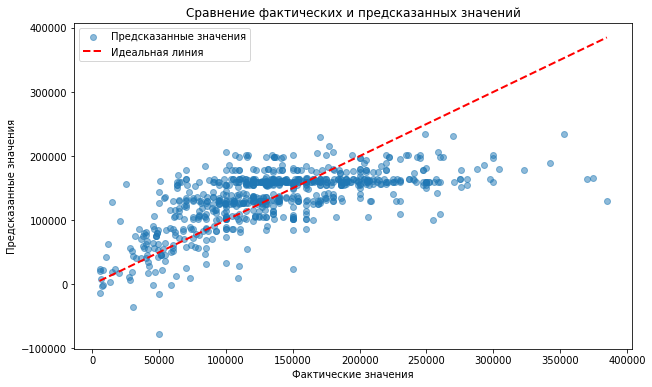

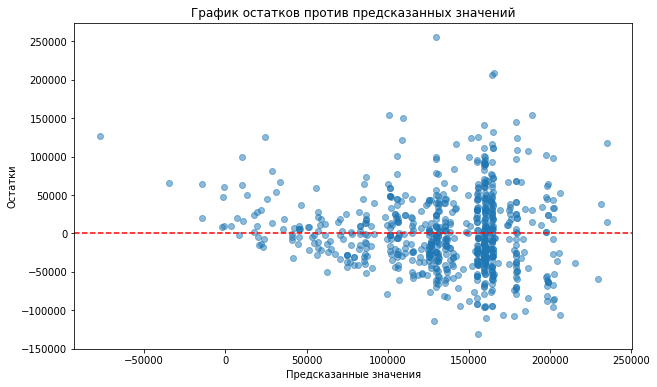

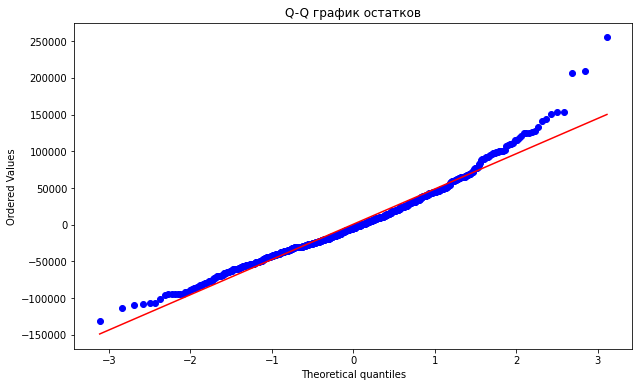

In [772]:
chart_result_analysis(model_ridge, X_test_encoded, y_test)

<div style="background-color: rgba(255, 255, 0, 0.1); color: black; padding: 10px;">
    <h2>RandomForest</h2>
</div>

### Preparing

In [777]:
data = pd.read_csv( './Other/baselines/ds_salaries.csv', sep= ',')
data['target'] = data.salary_in_usd
data.drop(['salary','salary_currency','salary_in_usd'], inplace = True, axis =1)
df = data.copy()

In [778]:
categorical_features = list(df.select_dtypes(include=['object']).columns)
numeric_features = list(set(df.columns) - (set(categorical_features) | set(['target'])))

In [ ]:
# qq для определения преобразующей функци
qq_check = convert(df,numeric_features)

# преобразования
df = converter(df, numeric_features, method='standard')

# разделение и конвертация
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_encoded, X_test_encoded =  encode(X_train, y_train, X_test, categorical_features, 'onehot')

### Modeling

In [781]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
params = {
    'n_estimators': 100,  # количество деревьев в лесу
    #'criterion': 'gini',  # критерий качества разбиения
    'max_depth': None,  # максимальная глубина дерева
    'min_samples_split': 2,  # минимальное количество объектов, необходимое для разделения внутреннего узла
    'min_samples_leaf': 1,  # минимальное количество объектов в листе
    'min_weight_fraction_leaf': 0.0,  # минимальная взвешенная доля суммы весов во всех объектах, необходимая для листа
    'max_features': 'auto',  # количество признаков, учитываемых при поиске лучшего разбиения
    'max_leaf_nodes': None,  # максимальное количество листьев
    'min_impurity_decrease': 0.0,  # уменьшение неопределенности для разделения
    'bootstrap': True,  # использование бутстрапа для построения деревьев. False- для каждого дерева исп. все данные
    'oob_score': False,  # использование out-of-bag объектов для оценки точности
    'n_jobs': 1,  # количество ядер для параллельной работы
    'random_state': None,  # контроль за случайностью
    'verbose': 0,  # уровень детализации в процессе обучения
    'warm_start': False,  # использование предыдущего решения для добавления новых деревьев в ансамбль
    'ccp_alpha': 0.0,  # параметр для минимальной стоимости комплексной прунинга
    'max_samples': None  # количество объектов для обучения каждого базового дерева
}

model = RandomForestRegressor(**params)
model.fit(X_train_encoded, y_train)

In [785]:
valuation_r (model, X_test_encoded, y_test)

MSE: 2354554742.2669187
RMSE: 48523.75441231767
MAE: 36415.33279727755
R²: 0.4035764717946072


<div style="background-color: rgba(255, 255, 0, 0.1); color: black; padding: 10px;">
    <h2>Catboost</h2>
</div>

In [787]:
data = pd.read_csv( './Other/baselines/ds_salaries.csv', sep= ',')
data['target'] = data.salary_in_usd
data.drop(['salary','salary_currency','salary_in_usd'], inplace = True, axis =1)
df = data.copy()

categorical_features = list(df.select_dtypes(include=['object']).columns)
numeric_features = list(set(df.columns) - (set(categorical_features) | set(['target'])))

In [789]:
X = df[categorical_features + numeric_features]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [790]:
model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=3,
    cat_features=categorical_features,
    verbose=10,
    #auto_class_weights='Balanced'
)
model.fit(X_train, y_train)

0:	learn: 61476.9801629	total: 16.4ms	remaining: 3.26s
10:	learn: 52821.4747119	total: 60.8ms	remaining: 1.04s
20:	learn: 50456.5440517	total: 92.9ms	remaining: 792ms
30:	learn: 49421.1649243	total: 126ms	remaining: 688ms
40:	learn: 48978.9576043	total: 156ms	remaining: 605ms
50:	learn: 48726.2481097	total: 189ms	remaining: 553ms
60:	learn: 48524.9662889	total: 218ms	remaining: 497ms
70:	learn: 48431.2577541	total: 247ms	remaining: 448ms
80:	learn: 48311.8512183	total: 274ms	remaining: 402ms
90:	learn: 48233.3153088	total: 298ms	remaining: 357ms
100:	learn: 48166.1078866	total: 327ms	remaining: 320ms
110:	learn: 48090.0801557	total: 351ms	remaining: 281ms
120:	learn: 47990.5558381	total: 381ms	remaining: 249ms
130:	learn: 47925.6871278	total: 414ms	remaining: 218ms
140:	learn: 47878.3258948	total: 443ms	remaining: 185ms
150:	learn: 47793.8164324	total: 471ms	remaining: 153ms
160:	learn: 47709.2352093	total: 503ms	remaining: 122ms
170:	learn: 47653.3585890	total: 530ms	remaining: 89.9ms

In [792]:
valuation_r (model, X_test, y_test)

MSE: 2358618129.785927
RMSE: 48565.60644927567
MAE: 37314.968497525086
R²: 0.40254719017415974


# MultiClass

In [899]:
data = pd.read_csv( './Other/baselines/ds_salaries.csv', sep= ',')
data['target'] = data['company_size']
data.drop(['salary','salary_currency','company_size'], inplace = True, axis =1)
df = data.copy()

<div style="background-color: rgba(255, 255, 0, 0.1); color: black; padding: 10px;">
    <h2>Linear</h2>
</div>

### Preparation

In [ ]:
categorical_features = list(set(df.select_dtypes(include=['object']).columns) -set(['target']))
numeric_features = list(set(df.columns) - (set(categorical_features) | set(['target'])))

# qq для определения преобразующей функци
qq_check = convert(df,numeric_features)

# преобразования
df_tmp = converter(df, ['salary_in_usd'], method='sqrt')
df = converter(df_tmp, numeric_features, method='standard')

# разделение и конвертация
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [ ]:
X_train_encoded, X_test_encoded =  encode(X_train, y_train, X_test, categorical_features, 'onehot')

### Modeling

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
params = {
    'multi_class': 'multinomial',  # количество деревьев в лесу
    'solver': 'lbfgs', #'saga'
    #'penalty': 'l1', # 'elasticnet' или 'l1'  - только с солвером 'saga' 
    #'l1_ratio': 0.5, # только с elasticnet и solver = saga
    'C': 1.0,  # максимальная глубина дерева
    'max_iter': 10  # минимальное количество объектов, необходимое для разделения внутреннего узла
}

model = LogisticRegression(**params)
model.fit(X_train_encoded, y_train)

### Valuation

In [920]:
y_pred_mult = model.predict(X_test_encoded)
# probabilities = model.predict_proba(X_test_encoded)
# y_pred_mult = [np.argmax(probs) for probs in probabilities]

# threshold = 0.6
# y_pred_mult_custom_threshold = [np.argmax(probs) if np.max(probs) > threshold else -1 for probs in probabilities]

print(classification_report(y_test, y_pred_mult))


              precision    recall  f1-score   support

           L       0.48      0.40      0.43        91
           M       0.90      0.96      0.93       630
           S       0.33      0.10      0.15        30

    accuracy                           0.85       751
   macro avg       0.57      0.48      0.51       751
weighted avg       0.83      0.85      0.84       751



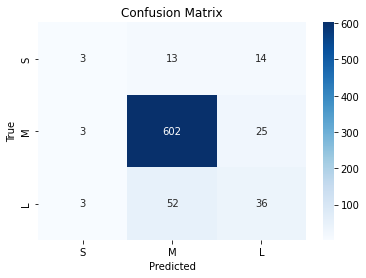

In [921]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_pred_mult, labels=['S', 'M', 'L'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['S', 'M', 'L'], yticklabels=['S', 'M', 'L'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [922]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Бинаризация меток
y_bin = label_binarize(y_test, classes=['S', 'M', 'L'])
n_classes = y_bin.shape[1]


# Вычисление ROC AUC для каждого класса
roc_auc = {}
for i in range(n_classes):
    roc_auc['Class ' + str(i)] = roc_auc_score(y_bin[:, i], model.predict_proba(X_test_encoded)[:, i])
    print(f"ROC AUC для класса {['S', 'M', 'L'][i]}:", roc_auc['Class ' + str(i)])


ROC AUC для класса S: 0.8606796116504855
ROC AUC для класса M: 0.8721763085399449
ROC AUC для класса L: 0.7767649017649018


In [923]:
roc_auc_ovo = roc_auc_score(y_bin, model.predict_proba(X_test_encoded), multi_class='ovo')
print("ROC AUC (One-vs-One):", roc_auc_ovo)


ROC AUC (One-vs-One): 0.8365402739851108


In [924]:
roc_auc_ovo = roc_auc_score(y_bin, model.predict_proba(X_test_encoded), multi_class='ovr')
print("ROC AUC (One-vs-One):", roc_auc_ovo)

ROC AUC (One-vs-One): 0.8365402739851108


<div style="background-color: rgba(255, 255, 0, 0.1); color: black; padding: 10px;">
    <h2>RandomForest</h2>
</div>

## Catboost